# DATA DOWNLOAD

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define tickers and date range
tickers = ['BTC-USD', 'AAPL', '^GSPC']
start_date = '2019-01-01'
end_date = '2024-12-31'

# Download adjusted close prices
data = yf.download(tickers, start=start_date, end=end_date)['Close']

# Compute daily log returns
log_returns = np.log(data / data.shift(1)).dropna()

[*********************100%***********************]  3 of 3 completed


# VISUALIZATION OF THE LOG-RETURNS

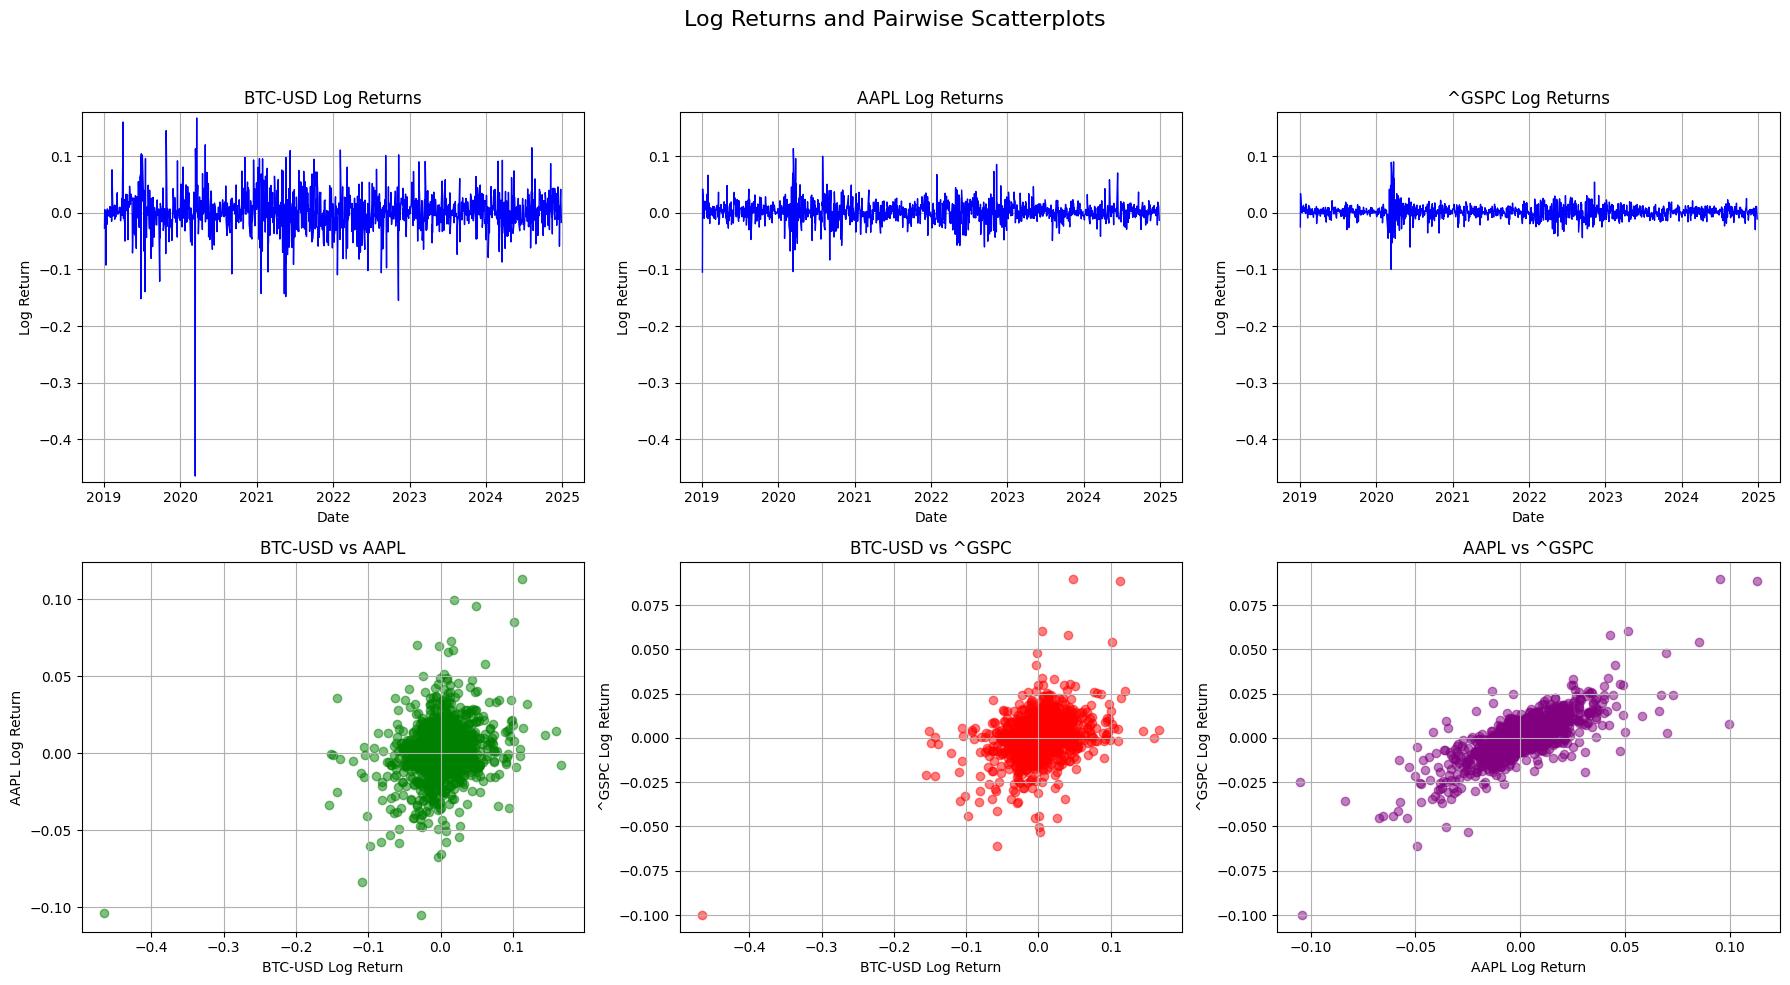

In [ ]:
# Determine common y-axis limits for the log return time series
ymin = log_returns.min().min()
ymax = log_returns.max().max()
padding = 0.01  # Optional padding for visual clarity
common_ylim = (ymin - padding, ymax + padding)

# Create a 2x3 plot
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Log Returns and Pairwise Scatterplots', fontsize=16)

# First row: Time series of log returns for each asset with common y-axis limits
for i, ticker in enumerate(tickers):
    axs[0, i].plot(log_returns.index, log_returns[ticker], color='blue', lw=1)
    axs[0, i].set_title(f'{ticker} Log Returns')
    axs[0, i].set_xlabel('Date')
    axs[0, i].set_ylabel('Log Return')
    axs[0, i].grid(True)
    axs[0, i].set_ylim(common_ylim)

# Second row: Pairwise scatterplots (using individual axis scales)
# Bitcoin vs Apple
axs[1, 0].scatter(log_returns['BTC-USD'], log_returns['AAPL'], alpha=0.5, color='green')
axs[1, 0].set_title('BTC-USD vs AAPL')
axs[1, 0].set_xlabel('BTC-USD Log Return')
axs[1, 0].set_ylabel('AAPL Log Return')
axs[1, 0].grid(True)

# Bitcoin vs SP500
axs[1, 1].scatter(log_returns['BTC-USD'], log_returns['^GSPC'], alpha=0.5, color='red')
axs[1, 1].set_title('BTC-USD vs ^GSPC')
axs[1, 1].set_xlabel('BTC-USD Log Return')
axs[1, 1].set_ylabel('^GSPC Log Return')
axs[1, 1].grid(True)

# Apple vs SP500
axs[1, 2].scatter(log_returns['AAPL'], log_returns['^GSPC'], alpha=0.5, color='purple')
axs[1, 2].set_title('AAPL vs ^GSPC')
axs[1, 2].set_xlabel('AAPL Log Return')
axs[1, 2].set_ylabel('^GSPC Log Return')
axs[1, 2].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("stocks.png")
plt.show()


# EXPECTATION AND COVARIANCE/CORRELATION MATRICES

In [ ]:
# Calculate the mean of the log returns
mean_returns = log_returns.mean()

# Calculate the covariance matrix of the log returns
cov_matrix = log_returns.cov()

# Calculate the correlation matrix of the log returns
corr_matrix = log_returns.corr()

# Print the results
print("Mean of Log Returns:\n", mean_returns)
print("\nCovariance Matrix:\n", cov_matrix)
print("\nCorrelation Matrix:\n", corr_matrix)


Mean of Log Returns:
 Ticker
AAPL       0.001254
BTC-USD    0.001522
^GSPC      0.000712
dtype: float64

Covariance Matrix:
 Ticker       AAPL   BTC-USD     ^GSPC
Ticker                               
AAPL     0.000358  0.000198  0.000183
BTC-USD  0.000198  0.001403  0.000172
^GSPC    0.000183  0.000172  0.000155

Correlation Matrix:
 Ticker       AAPL   BTC-USD     ^GSPC
Ticker                               
AAPL     1.000000  0.279922  0.776322
BTC-USD  0.279922  1.000000  0.369597
^GSPC    0.776322  0.369597  1.000000


# EXPECTATION AND VARIANCE OF A PORTFOLIO

In [ ]:
# Define portfolio weights: 40% BTC, 35% AAPL, 25% SP500
weights = np.array([0.40, 0.35, 0.25])

# Portfolio expected return as the weighted sum of individual expected returns
portfolio_expected_return = np.dot(weights, mean_returns)

# Portfolio variance computed using matrix multiplication
portfolio_variance = np.dot(weights, np.dot(cov_matrix, weights))

# Print the results
print("Portfolio Expected Return:", portfolio_expected_return)
print("Portfolio Variance:", portfolio_variance)


Portfolio Expected Return: 0.0012122274360057766
Portfolio Variance: 0.00036104432913596315


# PROBABILITY COMPUTATION WITH NORMAL PORTFOLIO

In [ ]:
from scipy.stats import norm

# Define the loss threshold (i.e., -5% return)
threshold = -0.05

# Calculate the z-score for the threshold
z_score = (threshold - portfolio_expected_return) / np.sqrt(portfolio_variance)

# Compute the probability of a loss greater than 5%
prob_loss = norm.cdf(z_score)
print("Probability of losing more than 5%:", prob_loss)


Probability of losing more than 5%: 0.003517162167571195


# FUNCTIONS TO ESTIMATE MULTIVARIATE T

In [ ]:
# --- Define the Negative Log-Likelihood for the Multivariate t ---
def mvt_neg_loglike(params, data, d):
    n = data.shape[0]
    # First d elements are the mean vector mu
    mu = params[:d]
    # Next d(d+1)/2 elements are the lower-triangular elements of the Cholesky factor L
    L_elements = params[d: d + (d*(d+1))//2]
    # Last parameter is nu (degrees of freedom)
    nu = params[-1]
    if nu <= 2:
        return np.inf  # variance exists only for nu>2

    # Reconstruct the lower-triangular matrix L (d x d)
    L = np.zeros((d, d))
    idx = 0
    for i in range(d):
        for j in range(i+1):
            L[i, j] = L_elements[idx]
            idx += 1
    # Enforce positivity on diagonal elements
    if np.any(np.diag(L) <= 0):
        return np.inf

    # Scale matrix (not the covariance) is Sigma = L L^T
    Sigma = L.dot(L.T)
    sign, logdetSigma = np.linalg.slogdet(Sigma)
    if sign <= 0:
        return np.inf

    # Compute Mahalanobis distances: q_i = (x_i-mu)^T Sigma^{-1} (x_i-mu)
    Sigma_inv = np.linalg.inv(Sigma)
    q = np.array([ (x - mu).T.dot(Sigma_inv).dot(x - mu) for x in data ])

    # Log-likelihood: sum over i of ln(1+q_i/nu)
    ll = ( n * ( gammaln((nu + d)/2) - gammaln(nu/2) - 0.5*d*np.log(nu*np.pi) - 0.5*logdetSigma )
         - ((nu + d)/2) * np.sum(np.log(1 + q/nu)) )
    return -ll  # negative log-likelihood

# --- Fit the Multivariate t Distribution ---
def fit_multivariate_t(data):
    n, d = data.shape
    # Initial guess:
    # mu: sample mean, Sigma: sample covariance, use Cholesky of covariance as initial L,
    # and nu = 10.
    mu0 = np.mean(data, axis=0)
    Sigma0 = np.cov(data, rowvar=False)
    L0 = np.linalg.cholesky(Sigma0)
    # Extract lower-triangular elements of L0 in a vector (row-wise, for i>=j)
    L0_elements = []
    for i in range(d):
        for j in range(i+1):
            L0_elements.append(L0[i, j])
    L0_elements = np.array(L0_elements)
    nu0 = 10.0
    initial_params = np.concatenate([mu0, L0_elements, np.array([nu0])])

    # Set bounds: no bounds for mu; for diagonal elements of L (must be >0), and for nu (>2)
    bounds = []
    for i in range(d):
        bounds.append((None, None))  # mu
    for i in range(d):
        for j in range(i+1):
            if i == j:
                bounds.append((1e-6, None))
            else:
                bounds.append((None, None))
    bounds.append((2.1, None))  # nu must be > 2

    res = minimize(mvt_neg_loglike, initial_params, args=(data, d), bounds=bounds, method='L-BFGS-B')
    if not res.success:
        raise RuntimeError("MLE did not converge: " + res.message)

    params = res.x
    mu_est = params[:d]
    L_elements = params[d: d + (d*(d+1))//2]
    nu_est = params[-1]
    L_est = np.zeros((d, d))
    idx = 0
    for i in range(d):
        for j in range(i+1):
            L_est[i, j] = L_elements[idx]
            idx += 1
    Sigma_est = L_est.dot(L_est.T)
    return mu_est, Sigma_est, nu_est



# ESTIMATING MULTIVARIATE T

In [ ]:
data_array = log_returns.values  # shape: (n, d) where d=3
mu_est, Sigma_est, nu_est = fit_multivariate_t(data_array)
print("Estimated mu:", mu_est)
print("Estimated scale matrix Sigma:\n", Sigma_est)
print("Estimated nu:", nu_est)

Estimated mu: [0.00142841 0.00184956 0.00107681]
Estimated scale matrix Sigma:
 [[1.70208726e-04 6.58598027e-05 8.43441381e-05]
 [6.58598027e-05 6.50295972e-04 6.13428666e-05]
 [8.43441381e-05 6.13428666e-05 7.11018148e-05]]
Estimated nu: 3.7415987089143163


# PROBABILITY COMPUTATIONS T PORTFOLIO

In [ ]:
# Given portfolio parameters from your fit:
portfolio_mu = w.dot(mu_est)
portfolio_var = (nu_est / (nu_est - 2)) * (w.T.dot(Sigma_est).dot(w))

# Correct scale parameter for the t-distribution:
portfolio_scale = np.sqrt(portfolio_var * (nu_est - 2) / nu_est)

print("Portfolio Expected Return:", portfolio_mu)
print("Portfolio Variance:", portfolio_var)
print("Correct Scale Parameter:", portfolio_scale)

# Compute the probability of losing more than 5% (R_p < -0.05)
threshold = -0.05
prob_loss = t.cdf(threshold, df=nu_est, loc=portfolio_mu, scale=portfolio_scale)
print("Probability of losing more than 5%:", prob_loss)



Portfolio Expected Return: 0.0014879118795053997
Portfolio Variance: 0.00033811713547916367
Correct Scale Parameter: 0.012545241730249379
Probability of losing more than 5%: 0.008474381297287123
